In [1]:
from __future__ import annotations
from enum import IntEnum
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transforms.arg_map import ArgMap, ColumnBase, BOOL_MAP

In [2]:
TRAIN = pd.read_csv("data/train.csv")
TEST = pd.read_csv("data/test.csv")

display(TRAIN)
display(TEST)

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0              330911    7.8292   NaN        Q  
1    female  47.0      1      0              363272    7.0000   NaN        S  
2      male  62.0      0      0              240276    9.6875   NaN        Q  
3      male  27.0      0      0              315154    8.6625   NaN        S  
4    female  22.0      1      1             3101298   12.2875   NaN        S  
..      ...   ...    ...    ...                 ...       ...   ...      ...  
413    male   NaN      0      0           A.5. 3236    8.0500   NaN        S  
414  female  39.0      0      0            PC 17758  108.9000  C105        C  
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416    male   NaN      0      0              359309    8.0500   NaN        S  
417    male   NaN      1      1                2668   22.3583   NaN        C  

[418 rows x 11 columns]

## 雑にpairplotしてみる
相関があるやるがあればパット見れるのでとりあえず描画 -> なにもわからなかった

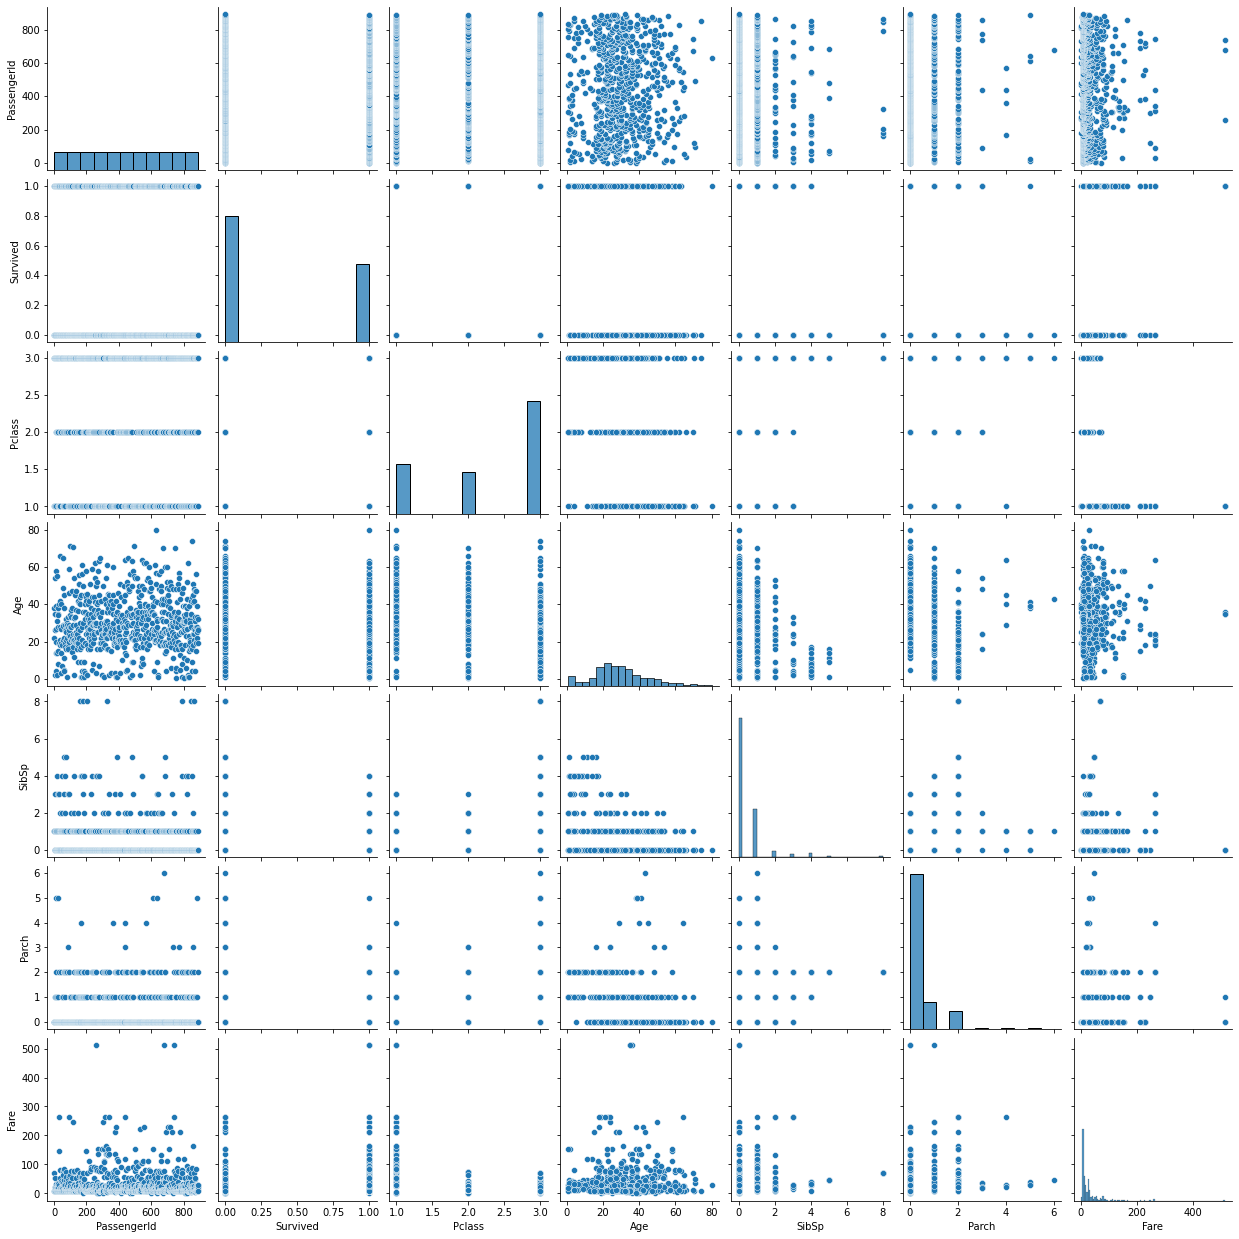

In [3]:
plt.close()
sns.pairplot(TRAIN)
plt.show()

## NaNのあるカラム
NaNのある行をdropするなり、NaNも許容する特徴量を作るなりしよう

In [4]:
TRAIN.isna().any(axis="index")

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

## カテゴリカルな変数で生存が割れそうか見てみる

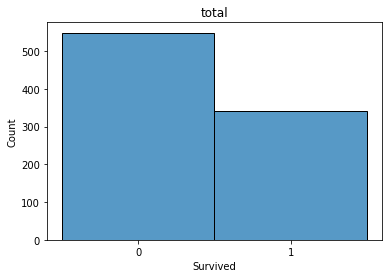

In [5]:
def plot_survived(df: pd.DataFrame, title: str = None) -> None:
    """生存分布の描画

    Args:
        df (pd.DataFrame): [description]
        title (str, optional): [description]. Defaults to None.
    """
    plt.close()
    sns.histplot(df.Survived.sort_values().astype(str))
    plt.title(title)
    plt.show()

plot_survived(TRAIN, "total")

### 性別で割れそう
男性のほうが生存してない

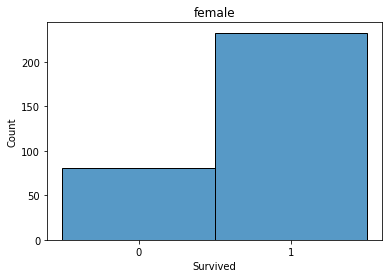

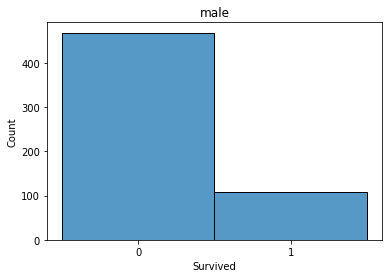

Empty DataFrame
Columns: []
Index: []

In [6]:
sex_map = ColumnBase([
    ArgMap("female", 0),
    ArgMap("male", 1),
])
TRAIN.groupby("Sex").apply(lambda x: plot_survived(x, x.Sex.iloc[0]))

### チケット階級だとどうだろう
上級が生き残りやすいとかありそう <- そうっぽい

1st: 助かってるほうが多い、2nd: どっこいどっこ、3rd: 助かっていないほうが多い


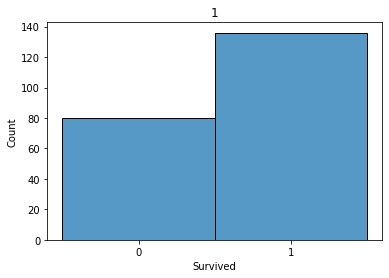

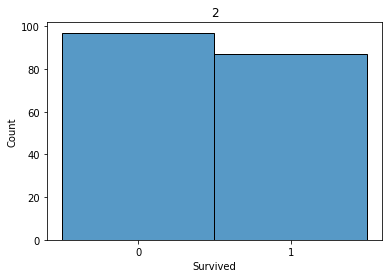

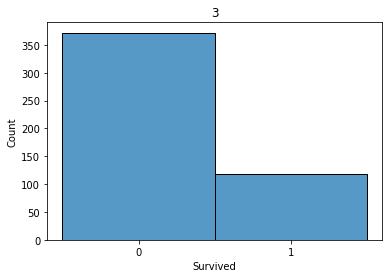

Empty DataFrame
Columns: []
Index: []

In [7]:
TRAIN.groupby("Pclass").apply(lambda x: plot_survived(x, x.Pclass.iloc[0]))

### 年齢
愚直にscatter取っ手もわからんから、年代で分けてplot_survivedｗするのがよさげ

~~20台未満か否かで変わりそう~~ 10歳未満が助かりやすい -> そういうカラムを追加する感じか

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

'count NA 177'

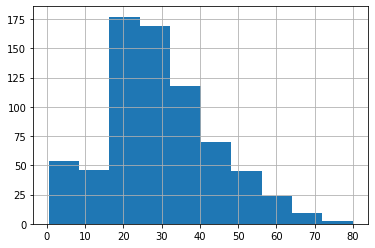

In [8]:
TRAIN.Age.hist()
display(TRAIN.Age.describe())
display(f"count NA {len(TRAIN.Age[TRAIN.Age.isna()])}")

class AgeClass(IntEnum):
    NA = 0
    UNDER10 = 10
    BETWEEN10AND20 = 11
    BETWEEN20AND40 = 21
    OVER40 = 41

    @classmethod
    def get_age_class(cls, age: float) -> AgeClass:
        if not isinstance(age, float) or age < 0:
            raise ValueError(f"invalid age: age={age}")

        if math.isnan(age):
            return cls.NA
        elif 0 <= age < 10:
            return cls.UNDER10
        elif 10 <= age < 20:
            return cls.BETWEEN10AND20
        elif 20 <= age < 40:
            return cls.BETWEEN20AND40
        elif 40 <= age:
            return cls.OVER40
        else:
            raise ValueError(f"unknown age: age={age}")

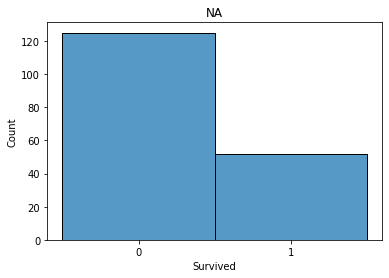

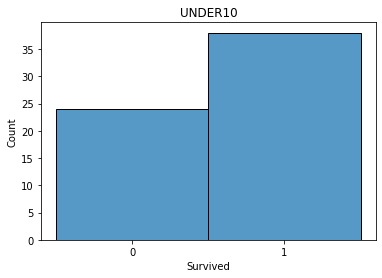

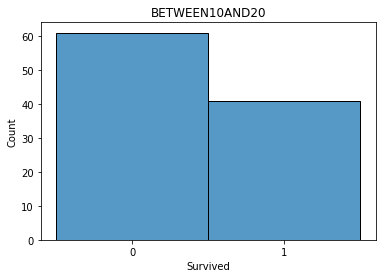

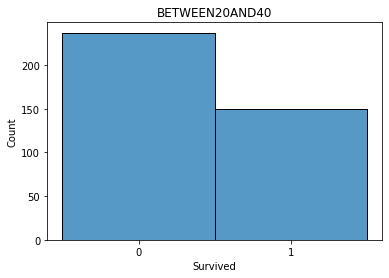

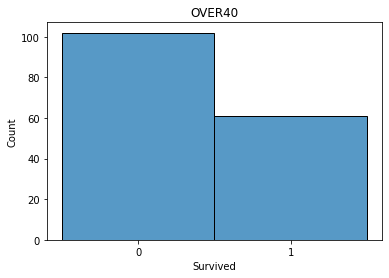

Empty DataFrame
Columns: []
Index: []

In [9]:
(
    TRAIN
    # 年齢区分を追加
    .assign(
        AgeClass=TRAIN.Age.apply(lambda x: AgeClass.get_age_class(x))
    )

    # 年齢区分ごとに生存状況を描画
    .groupby("AgeClass")
    .apply(lambda x: plot_survived(x, AgeClass(x.AgeClass.iloc[0]).name))
)

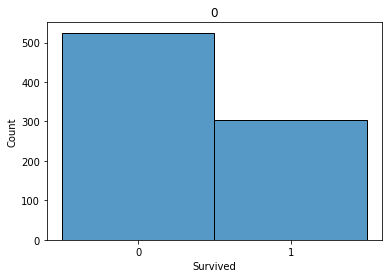

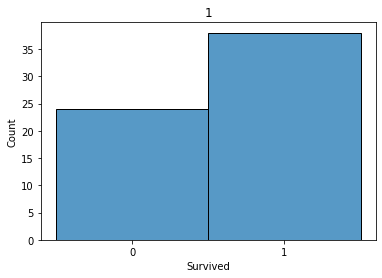

Empty DataFrame
Columns: []
Index: []

In [10]:
from transforms.column_under_10_years_old import column_under_10_years_old


display(
    TRAIN
    # 年齢区分を追加
    .assign(
        Under10YearsOld=column_under_10_years_old(TRAIN)
    )
    # 年齢区分ごとに生存状況を描画
    .groupby("Under10YearsOld")
    .apply(lambda x: plot_survived(x, x.Under10YearsOld.iloc[0]))
)


## 一緒に乗っている兄弟・配偶者の数
一人あるいは3人以上で来ている人は助からない...？

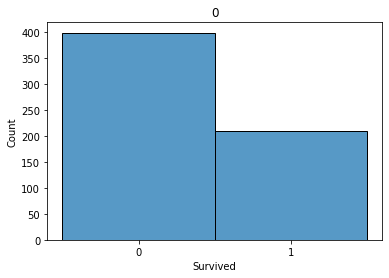

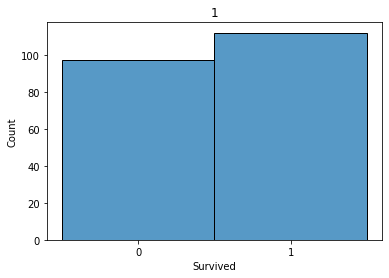

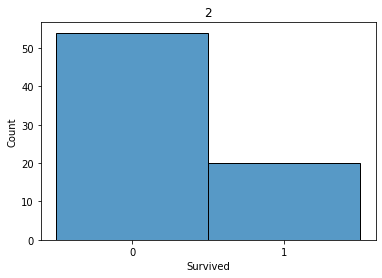

Empty DataFrame
Columns: []
Index: []

In [11]:
class Companions(IntEnum):
    SINGLE = 0
    PAIR = 1
    GROUP = 2

    @classmethod
    def get_companions(cls, sibsp: int) -> Companions:
        if sibsp == 0:
            return cls.SINGLE
        elif sibsp == 1:
            return cls.PAIR
        elif sibsp >= 2:
            return cls.GROUP
        else:
            raise ValueError(f"invalid sibsp {sibsp}")

(
    TRAIN
    .assign(
        Companions=TRAIN.SibSp.apply(Companions.get_companions)
    )
    .groupby("Companions")
    .apply(lambda x: plot_survived(x, title=x.Companions.iloc[0]))
)

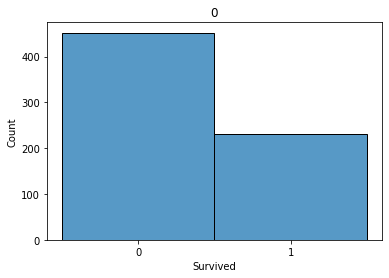

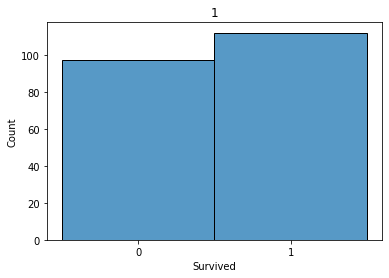

Empty DataFrame
Columns: []
Index: []

In [12]:
from transforms.column_is_pair import column_is_pair
(
    TRAIN
    .assign(
        IsPair=column_is_pair(TRAIN)
    )
    .groupby("IsPair")
    .apply(lambda x: plot_survived(x, title=x.IsPair.iloc[0]))
)

## 同行する親or子供の数 Parch
0だと助からないとかありそう、それ以外は微妙

カラムとしてはそのまま入れる

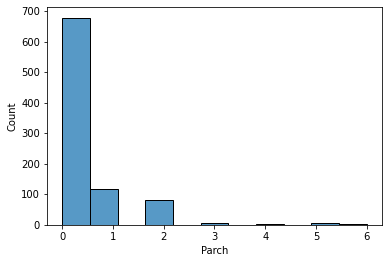

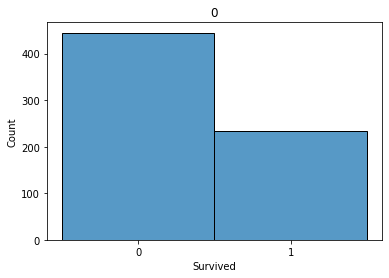

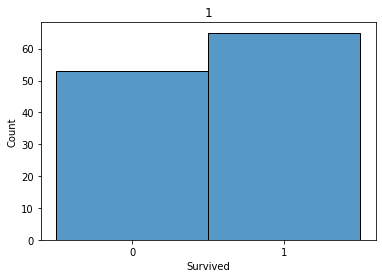

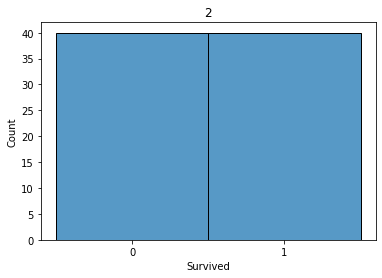

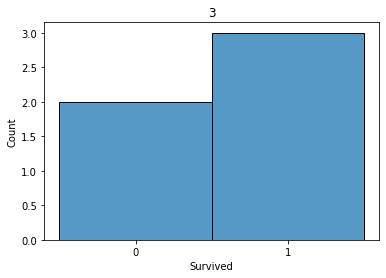

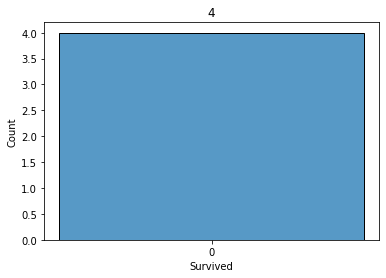

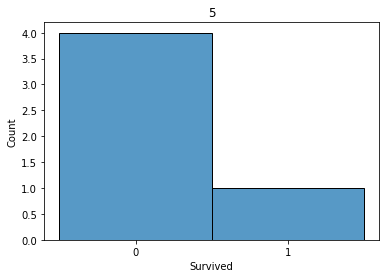

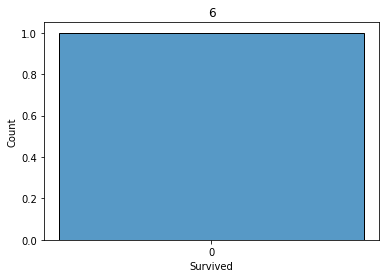

Empty DataFrame
Columns: []
Index: []

In [14]:
plt.close()
sns.histplot(TRAIN.Parch)
plt.show()

TRAIN.groupby("Parch").apply(lambda x: plot_survived(x, title=x.Parch.iloc[0]))